# Notebook 05: Phase II — Density-Dependent Coupling & Robustness

**Objective:** Investigate whether the Coupling Constant ($k$) depends on
**Central Surface Brightness ($\Sigma_0$)**, and test model robustness
against mass-to-light ratio assumptions.

## Work Packages

- **WP-A:** Variable Coupling — Parameterize $k(\Sigma_0)$ and re-fit the galaxies that hit the $k$ upper bound.
- **WP-C:** Robustness — Test whether $\omega$ is stable against $\Upsilon$ variations.
- **M33 Re-Analysis:** Compare M33 in pure linear mode vs. tapered mode.

## Deliverables

| Deliverable | Status |
|-|-|
| Split Plot (LSB vs HSB populations) | This notebook |
| Scaling Law ($k$ vs $\Sigma_0$) | This notebook |
| M33 Linear Re-Analysis | This notebook |
| Sensitivity Table ($\omega$ vs $\Upsilon$) | This notebook |

In [23]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

from src.physics import (
    compute_v_bary,
    fit_omega,
    fit_omega_tapered,
    fit_omega_tapered_kRd,
    compute_bic,
)
from src.ingest import (
    parse_sparc_metadata_mrt,
    load_m33_corbelli2014_data,
)
from src.database import get_engine, get_session, query_profiles_as_dataframe
from src.utils import setup_logger, get_project_root

sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

# Constants (consistent with Phase I)
UPSILON_DISK = 0.5
UPSILON_BULGE = 0.7
K_UPPER_BOUND = 20.0  # Upper bound used in Phase I fits

# Paths
PROJECT_ROOT = get_project_root()
RESULTS_DIR = PROJECT_ROOT / 'results'
TABLES_DIR = RESULTS_DIR / 'tables'
FIGURES_DIR = RESULTS_DIR / 'figures'
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')

Project root: C:\Projects\ISM\baryonic-omega-analysis


---
## 1. Load Phase I Results & Classify Populations

Load the batch results from Notebook 04 and SPARC metadata. Classify galaxies
into **"Tapered"** (well-fit, $k$ away from bounds) vs **"Linear"** ($k \to 20$,
optimizer hit the upper bound).

In [24]:
# Load Phase I batch results
batch_df = pd.read_csv(TABLES_DIR / 'SPARC_tapered_batch_results.csv')
print(f'Phase I results: {len(batch_df)} galaxies')

# Load SPARC metadata for additional properties
metadata_path = PROJECT_ROOT / 'data' / 'raw' / 'SPARC_Lelli2016c.mrt'
meta_df = parse_sparc_metadata_mrt(metadata_path)
meta_lookup = meta_df.set_index('galaxy_id')

# Merge disk surface brightness from metadata
batch_df['sb_disk'] = batch_df['Galaxy_ID'].map(
    lambda g: meta_lookup.loc[g, 'sb_disk'] if g in meta_lookup.index else np.nan
)

# Compute central surface brightness: Sigma_0 = L_tot / (2*pi*R_d^2)
# L_tot is in 10^9 Lsun, R_d in kpc -> convert to Lsun/kpc^2
batch_df['Sigma_0'] = (
    batch_df['luminosity_1e9_Lsun'] * 1e9
    / (2 * np.pi * batch_df['R_d_kpc']**2)
)

# Classify populations
K_THRESHOLD = K_UPPER_BOUND - 0.01  # k values at the bound
batch_df['population'] = np.where(
    batch_df['k_coupling'] >= K_THRESHOLD, 'Boundary Solution (k = 20)', 'Boundary Solution (k < 20)'
)

# Also flag galaxies hitting the lower k bound
K_LOWER_BOUND = 0.1
batch_df.loc[batch_df['k_coupling'] <= K_LOWER_BOUND + 0.01, 'population'] = 'Boundary Solution (k < 20)'

tapered = batch_df[batch_df['population'] == 'Boundary Solution (k < 20)'].copy()
linear = batch_df[batch_df['population'] == 'Boundary Solution (k = 20)'].copy()

print(f'\nPopulation classification:')
print(f'  Tapered (good fits): {len(tapered)} ({len(tapered)/len(batch_df)*100:.1f}%)')
print(f'  Linear (hit bounds): {len(linear)} ({len(linear)/len(batch_df)*100:.1f}%)')
print(f'\nLinear galaxies: {linear["Galaxy_ID"].tolist()}')

2026-02-15 07:43:28 | INFO     | src.ingest | Parsed metadata for 175 galaxies


Phase I results: 118 galaxies

Population classification:
  Tapered (good fits): 99 (83.9%)
  Linear (hit bounds): 19 (16.1%)

Linear galaxies: ['D631-7', 'DDO168', 'F571-8', 'NGC0891', 'NGC3521', 'NGC3726', 'NGC4013', 'NGC4088', 'NGC4157', 'NGC4217', 'NGC5005', 'NGC5055', 'NGC6195', 'NGC7331', 'UGC02916', 'UGC03580', 'UGC06614', 'UGC09037', 'UGC11557']


### Deliverable: The "Split" Plot

Boxplots comparing Luminosity, Surface Brightness, and $V_{\text{flat}}$ between
the two populations. If the "Linear" galaxies are systematically denser/brighter,
this proves the populations are physically different — not random failures.

C:\Users\schneider\AppData\Local\Temp\ipykernel_56780\26841148.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\schneider\AppData\Local\Temp\ipykernel_56780\26841148.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\schneider\AppData\Local\Temp\ipykernel_56780\26841148.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


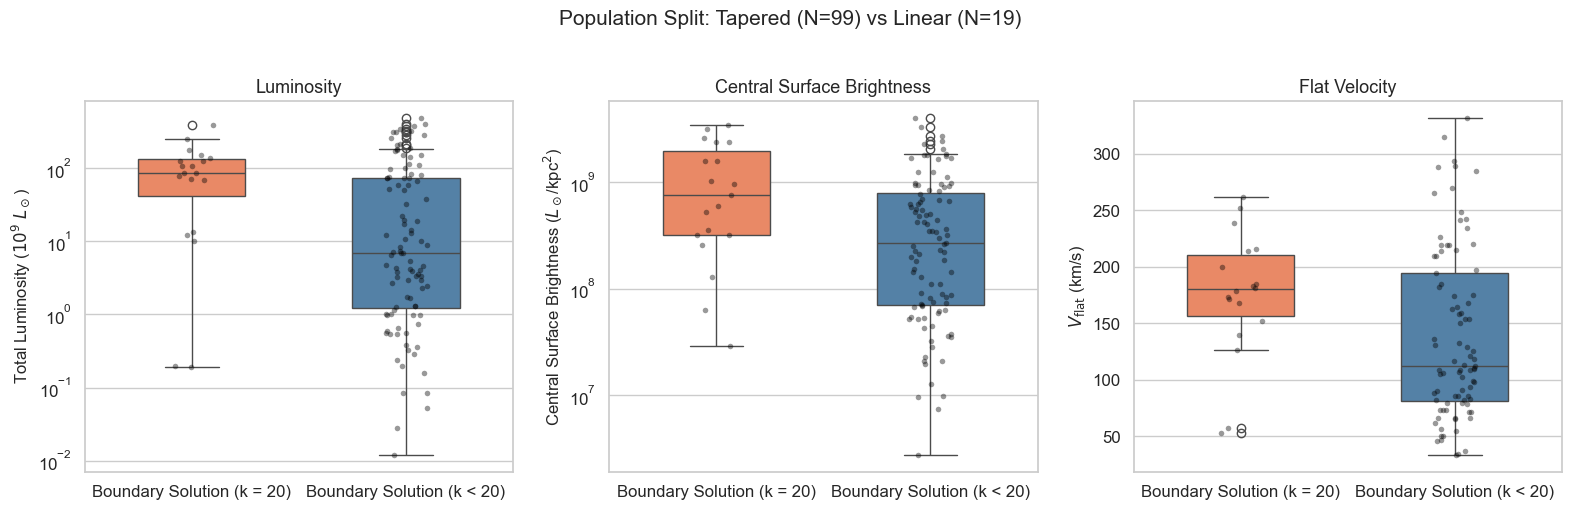

Figure saved: results/figures/split_populations.png

Population Statistics (median values)
  Luminosity (10^9 Lsun)          Tapered=      6.83  Linear=     85.30  p=0.0069 **
  Central SB (Lsun/kpc^2)         Tapered=267930889.53  Linear=760896469.57  p=0.0097 **
  V_flat (km/s)                   Tapered=    108.70  Linear=    179.00  p=0.0206 *
  R_d (kpc)                       Tapered=      2.42  Linear=      3.20  p=0.0814 n.s.


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

palette = {'Boundary Solution (k < 20)': 'steelblue', 'Boundary Solution (k = 20)': 'coral'}

# --- Panel 1: Luminosity ---
ax = axes[0]
sns.boxplot(
    data=batch_df, x='population', y='luminosity_1e9_Lsun',
    palette=palette, ax=ax, width=0.5,
)
sns.stripplot(
    data=batch_df, x='population', y='luminosity_1e9_Lsun',
    color='black', ax=ax, size=4, alpha=0.4, jitter=True,
)
ax.set_yscale('log')
ax.set_ylabel(r'Total Luminosity ($10^9$ $L_\odot$)', fontsize=12)
ax.set_xlabel('')
ax.set_title('Luminosity', fontsize=13)

# --- Panel 2: Central Surface Brightness ---
ax = axes[1]
sns.boxplot(
    data=batch_df, x='population', y='Sigma_0',
    palette=palette, ax=ax, width=0.5,
)
sns.stripplot(
    data=batch_df, x='population', y='Sigma_0',
    color='black', ax=ax, size=4, alpha=0.4, jitter=True,
)
ax.set_yscale('log')
ax.set_ylabel(r'Central Surface Brightness ($L_\odot$/kpc$^2$)', fontsize=12)
ax.set_xlabel('')
ax.set_title('Central Surface Brightness', fontsize=13)

# --- Panel 3: V_flat ---
ax = axes[2]
# Filter out v_flat = 0 (unmeasured)
plot_vflat = batch_df[batch_df['v_flat'] > 0].copy()
sns.boxplot(
    data=plot_vflat, x='population', y='v_flat',
    palette=palette, ax=ax, width=0.5,
)
sns.stripplot(
    data=plot_vflat, x='population', y='v_flat',
    color='black', ax=ax, size=4, alpha=0.4, jitter=True,
)
ax.set_ylabel(r'$V_{\mathrm{flat}}$ (km/s)', fontsize=12)
ax.set_xlabel('')
ax.set_title('Flat Velocity', fontsize=13)

plt.suptitle(
    f'Population Split: Tapered (N={len(tapered)}) vs Linear (N={len(linear)})',
    fontsize=15, y=1.02,
)
plt.tight_layout()
fig.savefig(
    FIGURES_DIR / 'split_populations.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print(f'Figure saved: results/figures/split_populations.png')

# Statistical comparison
print(f'\n{"="*60}')
print('Population Statistics (median values)')
print(f'{"="*60}')
for col, label in [
    ('luminosity_1e9_Lsun', 'Luminosity (10^9 Lsun)'),
    ('Sigma_0', 'Central SB (Lsun/kpc^2)'),
    ('v_flat', 'V_flat (km/s)'),
    ('R_d_kpc', 'R_d (kpc)'),
]:
    med_t = tapered[col].median()
    med_l = linear[col].median()
    # Mann-Whitney U test for significance
    stat, p_val = stats.mannwhitneyu(
        tapered[col].dropna(), linear[col].dropna(), alternative='two-sided'
    )
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'n.s.'
    print(f'  {label:30s}  Tapered={med_t:10.2f}  Linear={med_l:10.2f}  p={p_val:.4f} {sig}')

---
## 2. Work Package A: Variable Coupling $k(\Sigma_0)$

### Step 1: The Regression

Plot $k$ vs. $\Sigma_0$ for the "good" (Tapered) galaxies and fit:
$$k(\Sigma_0) = \alpha \cdot \Sigma_0 + \beta$$

**Hypothesis:** If denser galaxies have larger $k$, this would imply they
remain Newtonian to larger distances — the transition radius scales with
the baryonic concentration.

In [26]:
# Use only tapered galaxies with valid Sigma_0 for the regression
reg_df = tapered[tapered['Sigma_0'].notna() & (tapered['Sigma_0'] > 0)].copy()

# Log-space regression (surface brightness spans orders of magnitude)
log_sigma = np.log10(reg_df['Sigma_0'].values)
k_vals = reg_df['k_coupling'].values

# Linear regression: k = alpha * log10(Sigma_0) + beta
slope, intercept, r_value, p_value, std_err = stats.linregress(log_sigma, k_vals)

print(f'Regression: k = {slope:.3f} * log10(Sigma_0) + {intercept:.3f}')
print(f'  R^2 = {r_value**2:.4f}')
print(f'  p-value = {p_value:.2e}')
print(f'  Slope std error = {std_err:.3f}')
print(f'  N = {len(reg_df)}')

Regression: k = 0.530 * log10(Sigma_0) + -0.943
  R^2 = 0.0093
  p-value = 3.43e-01
  Slope std error = 0.556
  N = 99


### Deliverable: The Scaling Law Plot

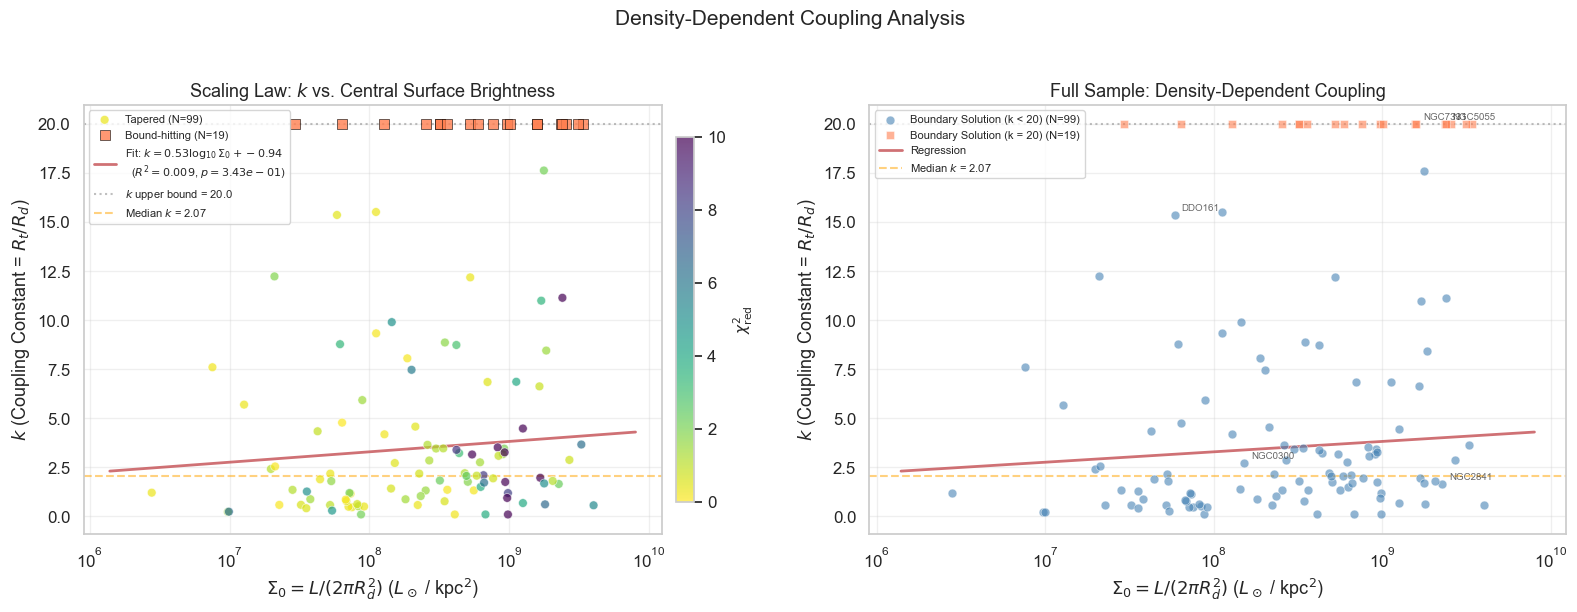

Figure saved: results/figures/k_vs_surface_brightness.png


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ==========================================================================
# Left panel: k vs Sigma_0 (the primary scaling law)
# ==========================================================================
ax = axes[0]

# Tapered galaxies (used in regression) — color by chi2_red quality
sc = ax.scatter(
    reg_df['Sigma_0'], reg_df['k_coupling'],
    c=reg_df['Chi2_red'], cmap='viridis_r', s=40, alpha=0.7,
    edgecolors='white', linewidth=0.5,
    label=f'Tapered (N={len(reg_df)})',
    vmin=0, vmax=10,
    zorder=3,
)
cbar = plt.colorbar(sc, ax=ax, pad=0.02, shrink=0.85)
cbar.set_label(r'$\chi^2_{\mathrm{red}}$', fontsize=11)

# Linear galaxies (the "failures")
linear_with_sigma = linear[linear['Sigma_0'].notna() & (linear['Sigma_0'] > 0)]
ax.scatter(
    linear_with_sigma['Sigma_0'], linear_with_sigma['k_coupling'],
    c='coral', s=60, marker='s', alpha=0.8, edgecolors='black', linewidth=0.5,
    label=f'Bound-hitting (N={len(linear_with_sigma)})',
    zorder=4,
)

# Regression line
sigma_range = np.logspace(
    np.log10(batch_df['Sigma_0'].dropna().min()) - 0.3,
    np.log10(batch_df['Sigma_0'].dropna().max()) + 0.3,
    100,
)
k_pred = slope * np.log10(sigma_range) + intercept
ax.plot(
    sigma_range, k_pred, 'r-', linewidth=2, alpha=0.8,
    label=(
        f'Fit: $k = {slope:.2f} \\log_{{10}}\\Sigma_0 + {intercept:.2f}$\n'
        f'  ($R^2 = {r_value**2:.3f}$, $p = {p_value:.2e}$)'
    ),
)

# Reference lines
ax.axhline(K_UPPER_BOUND, color='gray', linestyle=':', alpha=0.5,
           label=f'$k$ upper bound = {K_UPPER_BOUND}')
ax.axhline(np.median(k_vals), color='orange', linestyle='--', alpha=0.5,
           label=f'Median $k$ = {np.median(k_vals):.2f}')

ax.set_xscale('log')
ax.set_xlabel(r'$\Sigma_0 = L / (2\pi R_d^2)$ ($L_\odot$ / kpc$^2$)', fontsize=13)
ax.set_ylabel('$k$ (Coupling Constant = $R_t / R_d$)', fontsize=13)
ax.set_title('Scaling Law: $k$ vs. Central Surface Brightness', fontsize=13)
ax.legend(fontsize=8, loc='upper left')
ax.grid(True, alpha=0.3)

# ==========================================================================
# Right panel: k vs Sigma_0, full sample with population color-coding
# ==========================================================================
ax = axes[1]

all_with_sigma = batch_df[batch_df['Sigma_0'].notna() & (batch_df['Sigma_0'] > 0)].copy()
palette = {'Boundary Solution (k < 20)': 'steelblue', 'Boundary Solution (k = 20)': 'coral'}

for pop, color in palette.items():
    mask = all_with_sigma['population'] == pop
    sub = all_with_sigma[mask]
    marker = 'o' if pop == 'Boundary Solution (k < 20)' else 's'
    ax.scatter(
        sub['Sigma_0'], sub['k_coupling'],
        c=color, s=40, marker=marker, alpha=0.6,
        edgecolors='white', linewidth=0.5,
        label=f'{pop} (N={len(sub)})',
        zorder=3,
    )

# Regression line (same as left panel)
ax.plot(sigma_range, k_pred, 'r-', linewidth=2, alpha=0.8, label='Regression')

# Annotate a few notable galaxies
for _, row in all_with_sigma.iterrows():
    gid = row['Galaxy_ID']
    if gid in ('NGC5055', 'NGC7331', 'NGC2841', 'DDO161', 'NGC0300'):
        ax.annotate(
            gid, (row['Sigma_0'], row['k_coupling']),
            fontsize=7, alpha=0.7,
            xytext=(5, 3), textcoords='offset points',
        )

ax.axhline(K_UPPER_BOUND, color='gray', linestyle=':', alpha=0.5)
ax.axhline(np.median(k_vals), color='orange', linestyle='--', alpha=0.5,
           label=f'Median $k$ = {np.median(k_vals):.2f}')

ax.set_xscale('log')
ax.set_xlabel(r'$\Sigma_0 = L / (2\pi R_d^2)$ ($L_\odot$ / kpc$^2$)', fontsize=13)
ax.set_ylabel('$k$ (Coupling Constant = $R_t / R_d$)', fontsize=13)
ax.set_title('Full Sample: Density-Dependent Coupling', fontsize=13)
ax.legend(fontsize=8, loc='upper left')
ax.grid(True, alpha=0.3)

plt.suptitle(
    'Density-Dependent Coupling Analysis',
    fontsize=15, y=1.02,
)
plt.tight_layout()
fig.savefig(
    FIGURES_DIR / 'k_vs_surface_brightness.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print(f'Figure saved: results/figures/k_vs_surface_brightness.png')

### Step 2: The "Unified" Run

For the "Linear" galaxies that hit the $k$ bounds, predict $k$ from their
$\Sigma_0$ using the regression, then re-fit with $R_t$ constrained around
the predicted value.

In [28]:
# Connect to the database for profile access
engine = get_engine()
session = get_session(engine)

unified_results = []

for _, row in linear.iterrows():
    gid = row['Galaxy_ID']
    sigma_0 = row['Sigma_0']
    r_d = row['R_d_kpc']
    
    if pd.isna(sigma_0) or sigma_0 <= 0:
        print(f'  {gid}: skipped (no valid Sigma_0)')
        continue
    
    # Predict k from the regression
    k_predicted = slope * np.log10(sigma_0) + intercept
    k_predicted = max(k_predicted, 0.1)  # physical floor
    rt_predicted = k_predicted * r_d
    
    # Load profile from database
    df = query_profiles_as_dataframe(session, gid)
    if df.empty:
        print(f'  {gid}: skipped (no profile data in DB)')
        continue
    
    radius = df['radius_kpc'].values
    v_obs = df['v_obs'].values
    v_err = df['v_err'].values
    v_gas = df['v_gas'].values
    v_disk = df['v_disk'].values
    v_bulge = df['v_bulge'].values
    
    v_bary = compute_v_bary(
        v_gas, v_disk, v_bulge,
        upsilon_disk=UPSILON_DISK,
        upsilon_bulge=UPSILON_BULGE,
    )
    
    # Re-fit with R_t constrained near the predicted value.
    # Use generous bounds around the prediction so the optimizer has room.
    rt_lo = max(rt_predicted * 0.3, 0.1)
    rt_hi = max(rt_predicted * 3.0, 1.0)
    
    # Ensure initial guess for omega and R_t lie within the bounds.
    # fit_omega_tapered uses p0=[5.0, 5.0] by default, which may be
    # outside our custom rt_bounds. Use the midpoint of bounds instead.
    omega_lo, omega_hi = 0.0, 200.0
    p0_omega = np.clip(5.0, omega_lo, omega_hi)
    p0_rt = np.clip(rt_predicted, rt_lo, rt_hi)
    
    # Call curve_fit directly with correct initial guesses, since
    # fit_omega_tapered hard-codes p0. We replicate its logic here.
    from scipy.optimize import curve_fit
    
    # Safe errors
    positive_errs = v_err[v_err > 0]
    min_err = float(np.min(positive_errs)) if len(positive_errs) > 0 else 1.0
    v_err_safe = np.where(v_err > 0, v_err, min_err)
    
    flag_v_obs_lt_v_bary = bool(np.any(v_obs < v_bary))
    
    def _model(r, omega, r_t, _vb=v_bary):
        return _vb + omega * r / (1.0 + r / r_t)
    
    try:
        popt, pcov = curve_fit(
            _model, radius, v_obs,
            p0=[p0_omega, p0_rt],
            sigma=v_err_safe, absolute_sigma=True,
            bounds=([omega_lo, rt_lo], [omega_hi, rt_hi]),
        )
        omega_best = float(popt[0])
        rt_best = float(popt[1])
        perr = np.sqrt(np.diag(pcov))
        converged = True
    except RuntimeError:
        omega_best = rt_best = float('nan')
        perr = [float('nan'), float('nan')]
        converged = False
    
    v_model = _model(radius, omega_best, rt_best)
    residuals = v_obs - v_model
    chi2 = float(np.sum((residuals / v_err_safe) ** 2))
    dof = max(len(radius) - 2, 1)
    reduced_chi2 = chi2 / dof
    rmse = float(np.sqrt(np.mean(residuals**2)))
    bic = compute_bic(len(radius), 2, chi2)
    k_actual = rt_best / r_d if r_d > 0 else np.nan
    
    unified_results.append({
        'Galaxy_ID': gid,
        'Sigma_0': sigma_0,
        'k_predicted': k_predicted,
        'k_fitted': k_actual,
        'R_t_predicted': rt_predicted,
        'R_t_fitted': rt_best,
        'Omega_original': row['Omega'],
        'Omega_unified': omega_best,
        'Chi2_red_original': row['Chi2_red'],
        'Chi2_red_unified': reduced_chi2,
        'RMSE_original': row['RMSE'],
        'RMSE_unified': rmse,
        'BIC_original': row['BIC'],
        'BIC_unified': bic,
        'converged': converged,
    })

session.close()

unified_df = pd.DataFrame(unified_results)

print(f'\nUnified Run Results: {len(unified_df)} galaxies re-fit')
print(f'Converged: {unified_df["converged"].sum()}')

# Save
out_path = TABLES_DIR / 'SPARC_unified_coupling_results.csv'
unified_df.to_csv(out_path, index=False, float_format='%.6f')
print(f'Saved: {out_path}')

display(unified_df)


Unified Run Results: 19 galaxies re-fit
Converged: 19
Saved: C:\Projects\ISM\baryonic-omega-analysis\results\tables\SPARC_unified_coupling_results.csv


,Galaxy_ID,Sigma_0,k_predicted,k_fitted,R_t_predicted,R_t_fitted,Omega_original,Omega_unified,Chi2_red_original,Chi2_red_unified,RMSE_original,RMSE_unified,BIC_original,BIC_unified,converged
0,D631-7,6.366198e+07,3.191124,9.573373,2.233787,6.701361,7.917548,9.798562,4.461459,6.838147,4.301165,5.669411,68.005602,101.279240,True
1,DDO168,2.921818e+07,3.011939,9.035818,3.072178,9.216534,9.794636,11.101743,6.502111,7.243020,3.639550,3.560261,56.622060,62.549327,True
2,F571-8,1.276394e+08,3.351173,10.053518,11.930174,35.790523,9.002395,10.071010,19.805596,20.783198,18.200405,18.740480,222.991453,233.745077,True
3,NGC0891,3.386005e+09,4.105418,12.316255,10.468817,31.406451,4.419054,4.926423,23.844531,25.474552,26.929812,27.519140,387.293234,413.373582,True
4,NGC3521,2.344109e+09,4.020808,12.062423,9.649939,28.949816,7.182817,8.070093,0.474386,0.511574,6.102326,6.719357,25.928205,27.378550,True
5,NGC3726,9.669627e+08,3.817072,11.451217,12.978046,38.934137,3.375431,3.864943,2.166739,2.541481,9.035200,11.086215,26.637207,30.384626,True
6,NGC4013,1.010216e+09,3.827140,11.481421,13.509806,40.529417,4.381593,5.127444,0.894040,1.411680,5.598793,6.325868,37.564410,55.164175,True
7,NGC4088,2.565215e+09,4.041546,12.124639,10.427190,31.281570,2.057907,2.318379,4.168627,4.546684,13.796735,14.415988,46.656079,50.436650,True
8,NGC4157,3.123132e+09,4.086825,12.260474,9.481433,28.444300,4.112799,4.821091,1.165387,1.649994,9.343223,11.104657,23.147233,30.416338,True
9,NGC4217,1.570614e+09,3.928675,11.786025,11.550305,34.650914,2.154996,2.293347,41.103258,41.709152,43.742356,44.087608,704.644259,714.944463,True


In [29]:
# Compare original vs unified chi2 and RMSE
if len(unified_df) > 0:
    converged_unified = unified_df[unified_df['converged']].copy()
    
    print('Unified Run: chi2_red comparison')
    print(f'  Original median chi2_red: {converged_unified["Chi2_red_original"].median():.2f}')
    print(f'  Unified  median chi2_red: {converged_unified["Chi2_red_unified"].median():.2f}')
    
    improved = (converged_unified['Chi2_red_unified'] < converged_unified['Chi2_red_original']).sum()
    print(f'  Improved: {improved}/{len(converged_unified)}')
    
    print(f'\nUnified Run: RMSE comparison')
    print(f'  Original median RMSE: {converged_unified["RMSE_original"].median():.2f} km/s')
    print(f'  Unified  median RMSE: {converged_unified["RMSE_unified"].median():.2f} km/s')
else:
    print('No unified results to compare (no Linear galaxies found).')

Unified Run: chi2_red comparison
  Original median chi2_red: 4.46
  Unified  median chi2_red: 6.84
  Improved: 0/19

Unified Run: RMSE comparison
  Original median RMSE: 12.45 km/s
  Unified  median RMSE: 12.72 km/s


---
## 3. Work Package C: Robustness — $\Upsilon$ Sensitivity

### The "Grid Search" Protocol

Select 3 representative galaxies (1 LSB, 1 HSB, 1 M33-like) and run the
tapered fit at $\Upsilon_{\text{disk}} \in \{0.3, 0.5, 0.8\}$.

**Question:** How sensitive is $\omega$ to the assumed mass-to-light ratio?
If $\omega$ is stable even as $\Upsilon$ varies significantly, the correction
is not an artifact of the baryonic decomposition choice.

In [30]:
# Select representative galaxies
# LSB: low Sigma_0, good fit -> DDO161 (Sigma_0 ~ low, Chi2_red = 0.45)
# HSB: high Sigma_0 -> NGC2841 (massive spiral, well-fit)
# M33-like: NGC0300 (nearby Sc, similar mass range)
SENSITIVITY_GALAXIES = {
    'DDO161': 'LSB (Dwarf Irregular)',
    'NGC2841': 'HSB (Massive Spiral)',
    'NGC0300': 'M33-like (Nearby Sc)',
}

UPSILON_GRID = [0.3, 0.5, 0.8]

engine = get_engine()
session = get_session(engine)

sensitivity_rows = []

for gid, description in SENSITIVITY_GALAXIES.items():
    print(f'\n{"="*50}')
    print(f'{gid} ({description})')
    print(f'{"="*50}')
    
    # Load profile
    df = query_profiles_as_dataframe(session, gid)
    if df.empty:
        print(f'  WARNING: No data for {gid} in database, skipping.')
        continue
    
    radius = df['radius_kpc'].values
    v_obs = df['v_obs'].values
    v_err = df['v_err'].values
    v_gas = df['v_gas'].values
    v_disk = df['v_disk'].values
    v_bulge = df['v_bulge'].values
    
    # Get R_d from metadata
    r_d = float(meta_lookup.loc[gid, 'r_disk_kpc'])
    
    omega_values = []
    
    for upsilon_d in UPSILON_GRID:
        v_bary = compute_v_bary(
            v_gas, v_disk, v_bulge,
            upsilon_disk=upsilon_d,
            upsilon_bulge=UPSILON_BULGE,
        )
        
        fit = fit_omega_tapered_kRd(
            radius, v_obs, v_err, v_bary,
            r_d=r_d,
            galaxy_id=gid,
            method_version=f'v2_sensitivity_Yd{upsilon_d:.1f}',
            upsilon_disk=upsilon_d,
            upsilon_bulge=UPSILON_BULGE,
        )
        
        omega_values.append(fit.omega_value)
        
        sensitivity_rows.append({
            'Galaxy_ID': gid,
            'Description': description,
            'Upsilon_disk': upsilon_d,
            'Omega': fit.omega_value,
            'Omega_err': fit.omega_uncertainty,
            'k_coupling': fit.k_value,
            'R_t_kpc': fit.rt_value,
            'Chi2_red': fit.reduced_chi_squared,
            'RMSE': fit.residuals_rmse,
            'converged': fit.converged,
        })
        
        print(f'  Y_d={upsilon_d:.1f}: omega={fit.omega_value:.3f} +/- {fit.omega_uncertainty:.3f}  '
              f'k={fit.k_value:.3f}  chi2_r={fit.reduced_chi_squared:.2f}  RMSE={fit.residuals_rmse:.2f}')
    
    # Compute percentage variation
    omega_ref = omega_values[1]  # Y_d=0.5 is the reference
    if omega_ref > 0:
        pct_range = (max(omega_values) - min(omega_values)) / omega_ref * 100
        print(f'  -> omega range: {min(omega_values):.3f} to {max(omega_values):.3f} '
              f'({pct_range:.1f}% variation)')

session.close()

sensitivity_df = pd.DataFrame(sensitivity_rows)

# Save
out_path = TABLES_DIR / 'upsilon_sensitivity.csv'
sensitivity_df.to_csv(out_path, index=False, float_format='%.6f')
print(f'\nSaved: {out_path}')

2026-02-15 07:43:30 | INFO     | src.physics | DDO161 [k*R_d taper]: omega=5.5188 +/- 0.3298  k=11.2634 +/- 1.5490  R_t=13.7413  chi2_r=0.37  RMSE=1.48
2026-02-15 07:43:30 | INFO     | src.physics | DDO161 [k*R_d taper]: omega=4.7457 +/- 0.2744  k=15.3731 +/- 2.4435  R_t=18.7552  chi2_r=0.46  RMSE=1.64
2026-02-15 07:43:30 | INFO     | src.physics | DDO161 [k*R_d taper]: omega=4.1721 +/- 0.2412  k=20.0000 +/- 3.7580  R_t=24.4000  chi2_r=0.89  RMSE=2.56
2026-02-15 07:43:30 | INFO     | src.physics | NGC2841 [k*R_d taper]: omega=52.6251 +/- 2.6956  k=0.9665 +/- 0.0557  R_t=3.5179  chi2_r=2.10  RMSE=7.62
2026-02-15 07:43:30 | INFO     | src.physics | NGC2841 [k*R_d taper]: omega=29.8014 +/- 1.3634  k=1.6549 +/- 0.0903  R_t=6.0238  chi2_r=2.27  RMSE=7.59
2026-02-15 07:43:30 | INFO     | src.physics | NGC2841 [k*R_d taper]: omega=12.5602 +/- 0.5235  k=4.1591 +/- 0.2450  R_t=15.1391  chi2_r=2.59  RMSE=9.16
2026-02-15 07:43:30 | INFO     | src.physics | NGC0300 [k*R_d taper]: omega=27.2043 +/-


DDO161 (LSB (Dwarf Irregular))
  Y_d=0.3: omega=5.519 +/- 0.330  k=11.263  chi2_r=0.37  RMSE=1.48
  Y_d=0.5: omega=4.746 +/- 0.274  k=15.373  chi2_r=0.46  RMSE=1.64
  Y_d=0.8: omega=4.172 +/- 0.241  k=20.000  chi2_r=0.89  RMSE=2.56
  -> omega range: 4.172 to 5.519 (28.4% variation)

NGC2841 (HSB (Massive Spiral))
  Y_d=0.3: omega=52.625 +/- 2.696  k=0.966  chi2_r=2.10  RMSE=7.62
  Y_d=0.5: omega=29.801 +/- 1.363  k=1.655  chi2_r=2.27  RMSE=7.59
  Y_d=0.8: omega=12.560 +/- 0.523  k=4.159  chi2_r=2.59  RMSE=9.16
  -> omega range: 12.560 to 52.625 (134.4% variation)

NGC0300 (M33-like (Nearby Sc))
  Y_d=0.3: omega=27.204 +/- 2.183  k=1.698  chi2_r=0.54  RMSE=3.74
  Y_d=0.5: omega=17.981 +/- 1.461  k=2.723  chi2_r=0.49  RMSE=3.53
  Y_d=0.8: omega=10.297 +/- 0.899  k=5.955  chi2_r=0.46  RMSE=3.41
  -> omega range: 10.297 to 27.204 (94.0% variation)

Saved: C:\Projects\ISM\baryonic-omega-analysis\results\tables\upsilon_sensitivity.csv


### Deliverable: The Stability Plot

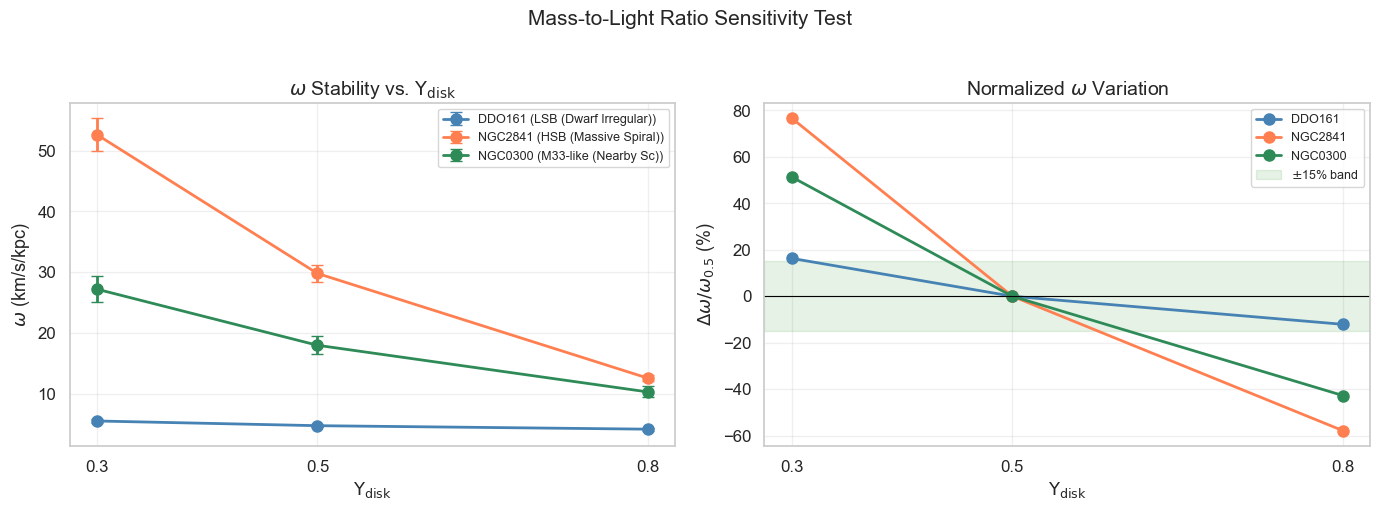

Figure saved: results/figures/upsilon_sensitivity.png


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'DDO161': 'steelblue', 'NGC2841': 'coral', 'NGC0300': 'seagreen'}

# --- Panel 1: omega vs Upsilon_disk ---
ax = axes[0]
for gid, desc in SENSITIVITY_GALAXIES.items():
    gal_data = sensitivity_df[sensitivity_df['Galaxy_ID'] == gid]
    if gal_data.empty:
        continue
    ax.errorbar(
        gal_data['Upsilon_disk'], gal_data['Omega'],
        yerr=gal_data['Omega_err'],
        fmt='-o', color=colors[gid], markersize=8, capsize=4, linewidth=2,
        label=f'{gid} ({desc})',
    )
ax.set_xlabel(r'$\Upsilon_{\mathrm{disk}}$', fontsize=13)
ax.set_ylabel(r'$\omega$ (km/s/kpc)', fontsize=13)
ax.set_title(r'$\omega$ Stability vs. $\Upsilon_{\mathrm{disk}}$', fontsize=14)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(UPSILON_GRID)

# --- Panel 2: Normalized omega (% change from Y_d=0.5) ---
ax = axes[1]
for gid, desc in SENSITIVITY_GALAXIES.items():
    gal_data = sensitivity_df[sensitivity_df['Galaxy_ID'] == gid]
    if gal_data.empty:
        continue
    omega_ref = gal_data.loc[gal_data['Upsilon_disk'] == 0.5, 'Omega'].values
    if len(omega_ref) == 0 or omega_ref[0] == 0:
        continue
    omega_ref = omega_ref[0]
    pct_change = (gal_data['Omega'].values - omega_ref) / omega_ref * 100
    ax.plot(
        gal_data['Upsilon_disk'].values, pct_change,
        '-o', color=colors[gid], markersize=8, linewidth=2,
        label=f'{gid}',
    )

ax.axhline(0, color='black', linewidth=0.8)
ax.axhspan(-15, 15, alpha=0.1, color='green', label=r'$\pm$15% band')
ax.set_xlabel(r'$\Upsilon_{\mathrm{disk}}$', fontsize=13)
ax.set_ylabel(r'$\Delta\omega / \omega_{0.5}$ (%)', fontsize=13)
ax.set_title(r'Normalized $\omega$ Variation', fontsize=14)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(UPSILON_GRID)

plt.suptitle(
    'Mass-to-Light Ratio Sensitivity Test',
    fontsize=15, y=1.02,
)
plt.tight_layout()
fig.savefig(
    FIGURES_DIR / 'upsilon_sensitivity.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print(f'Figure saved: results/figures/upsilon_sensitivity.png')

---
## 4. M33 Re-Analysis: Linear Mode

Re-run M33 with the pure linear model ($k \to \infty$, i.e., no taper).
Check if M33 "mimics HSB behavior" by preferring the linear form over
the tapered form.

In [32]:
# Load M33 Corbelli 2014 data
m33_data = load_m33_corbelli2014_data()

radius_m33 = m33_data['Rad'].values
v_obs_m33 = m33_data['Vobs'].values
v_err_m33 = m33_data['errV'].values
v_gas_m33 = m33_data['Vgas'].values
v_disk_m33 = m33_data['Vdisk'].values
v_bulge_m33 = m33_data['Vbul'].values

v_bary_m33 = compute_v_bary(
    v_gas_m33, v_disk_m33, v_bulge_m33,
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

# --- Linear fit (k -> infinity) ---
linear_fit = fit_omega(
    radius_m33, v_obs_m33, v_err_m33, v_bary_m33,
    galaxy_id='M33',
    method_version='v2_linear_reanalysis',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

# --- Tapered fit (for comparison) ---
tapered_fit = fit_omega_tapered(
    radius_m33, v_obs_m33, v_err_m33, v_bary_m33,
    galaxy_id='M33',
    method_version='v2_tapered_reanalysis',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

# BIC comparison
bic_linear = compute_bic(linear_fit.n_points, 1, linear_fit.chi_squared)
bic_tapered = compute_bic(tapered_fit.n_points, 2, tapered_fit.chi_squared)

print(f'M33 Re-Analysis')
print(f'{"="*60}')
print(f'{"Metric":25s} {"Linear":>15s} {"Rational Taper":>15s}')
print(f'{"-"*60}')
print(f'{"omega (km/s/kpc)":25s} {linear_fit.omega_value:15.3f} {tapered_fit.omega_value:15.3f}')
print(f'{"R_t (kpc)":25s} {"inf":>15s} {tapered_fit.rt_value:15.3f}')
print(f'{"RMSE (km/s)":25s} {linear_fit.residuals_rmse:15.3f} {tapered_fit.residuals_rmse:15.3f}')
print(f'{"chi2_red":25s} {linear_fit.reduced_chi_squared:15.3f} {tapered_fit.reduced_chi_squared:15.3f}')
print(f'{"BIC":25s} {bic_linear:15.1f} {bic_tapered:15.1f}')
print(f'{"Delta BIC (Lin - Tap)":25s} {bic_linear - bic_tapered:15.1f}')
print(f'{"Converged":25s} {str(linear_fit.converged):>15s} {str(tapered_fit.converged):>15s}')

# M33 Sigma_0
if 'M33' in meta_lookup.index:
    m33_lum = float(meta_lookup.loc['M33', 'luminosity_band_36'])
    m33_rd = float(meta_lookup.loc['M33', 'r_disk_kpc'])
    m33_sigma0 = m33_lum * 1e9 / (2 * np.pi * m33_rd**2)
    print(f'\nM33 Sigma_0 = {m33_sigma0:.2e} Lsun/kpc^2')
    print(f'M33 R_d = {m33_rd:.2f} kpc')
    k_pred_m33 = slope * np.log10(m33_sigma0) + intercept
    print(f'Predicted k from regression: {k_pred_m33:.2f}')
    print(f'Actual k from tapered fit: {tapered_fit.rt_value / m33_rd:.2f}')

2026-02-15 07:43:30 | INFO     | src.ingest | Loaded Corbelli 2014 Table 1: 58 data points (R = 0.24 – 22.72 kpc)
2026-02-15 07:43:32 | INFO     | src.ingest | Computed velocity components: V_gas peak=38.0 km/s, V_disk peak=62.2 km/s
2026-02-15 07:43:32 | INFO     | src.physics | M33: omega=6.9749 +/- 0.0418 km/s/kpc  chi2_r=72.91  RMSE=31.05 km/s
2026-02-15 07:43:32 | INFO     | src.physics | M33 [rational taper]: omega=42.9747 +/- 1.6351  R_t=1.9782 +/- 0.0966  chi2_r=4.57  RMSE=9.49


M33 Re-Analysis
Metric                             Linear  Rational Taper
------------------------------------------------------------
omega (km/s/kpc)                    6.975          42.975
R_t (kpc)                             inf           1.978
RMSE (km/s)                        31.053           9.486
chi2_red                           72.907           4.573
BIC                                4159.8           264.2
Delta BIC (Lin - Tap)              3895.5
Converged                            True            True


In [33]:
# Save M33 comparison table
m33_comparison = pd.DataFrame([
    {
        'Model': 'Linear (k=inf)',
        'Omega_km_s_kpc': linear_fit.omega_value,
        'Omega_err': linear_fit.omega_uncertainty,
        'R_t_kpc': np.inf,
        'RMSE_km_s': linear_fit.residuals_rmse,
        'Chi2_red': linear_fit.reduced_chi_squared,
        'BIC': bic_linear,
        'n_points': linear_fit.n_points,
        'converged': linear_fit.converged,
    },
    {
        'Model': 'Rational Taper',
        'Omega_km_s_kpc': tapered_fit.omega_value,
        'Omega_err': tapered_fit.omega_uncertainty,
        'R_t_kpc': tapered_fit.rt_value,
        'RMSE_km_s': tapered_fit.residuals_rmse,
        'Chi2_red': tapered_fit.reduced_chi_squared,
        'BIC': bic_tapered,
        'n_points': tapered_fit.n_points,
        'converged': tapered_fit.converged,
    },
])

out_path = TABLES_DIR / 'M33_linear_reanalysis.csv'
m33_comparison.to_csv(out_path, index=False, float_format='%.6f')
print(f'Saved: {out_path}')
display(m33_comparison)

Saved: C:\Projects\ISM\baryonic-omega-analysis\results\tables\M33_linear_reanalysis.csv


,Model,Omega_km_s_kpc,Omega_err,R_t_kpc,RMSE_km_s,Chi2_red,BIC,n_points,converged
0,Linear (k=inf),6.974863,0.041827,inf,31.053169,72.907215,4159.771675,58,True
1,Rational Taper,42.974740,1.635138,1.978158,9.486078,4.573312,264.226376,58,True


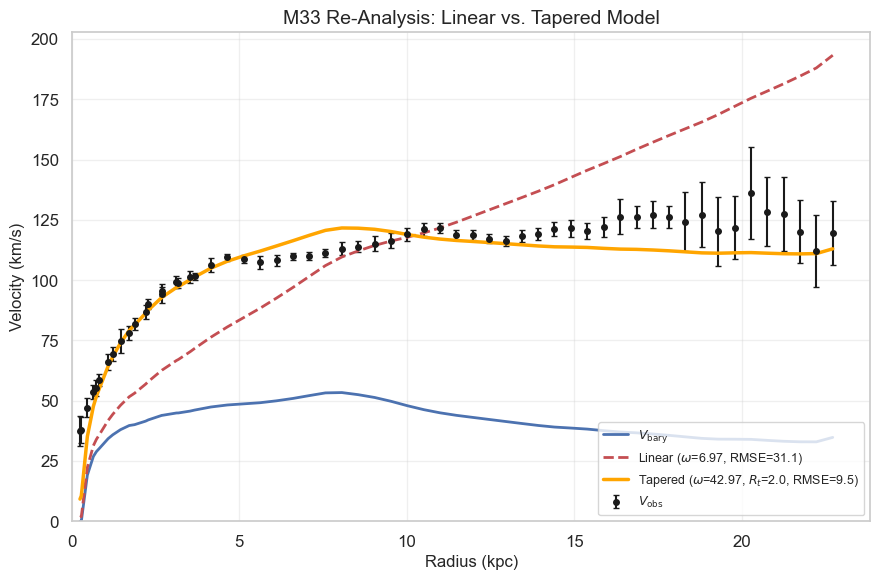

Figure saved: results/figures/M33_linear_reanalysis.png


In [34]:
# M33 comparison plot
fig, ax = plt.subplots(figsize=(9, 6))

# Observed data
ax.errorbar(
    radius_m33, v_obs_m33, yerr=v_err_m33,
    fmt='ko', markersize=4, capsize=2, label=r'$V_{\mathrm{obs}}$',
)

# V_bary
ax.plot(radius_m33, v_bary_m33, 'b-', linewidth=2, label=r'$V_{\mathrm{bary}}$')

# Linear model
ax.plot(
    radius_m33, linear_fit.v_model, 'r--', linewidth=2,
    label=rf'Linear ($\omega$={linear_fit.omega_value:.2f}, RMSE={linear_fit.residuals_rmse:.1f})',
)

# Tapered model
ax.plot(
    radius_m33, tapered_fit.v_model, color='orange', linewidth=2.5,
    label=rf'Tapered ($\omega$={tapered_fit.omega_value:.2f}, $R_t$={tapered_fit.rt_value:.1f}, RMSE={tapered_fit.residuals_rmse:.1f})',
)

ax.set_xlabel('Radius (kpc)', fontsize=12)
ax.set_ylabel('Velocity (km/s)', fontsize=12)
ax.set_title('M33 Re-Analysis: Linear vs. Tapered Model', fontsize=14)
ax.legend(loc='lower right', fontsize=9)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(
    FIGURES_DIR / 'M33_linear_reanalysis.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print(f'Figure saved: results/figures/M33_linear_reanalysis.png')

---
## 5. Summary & Session Log

In [35]:
log = setup_logger(
    'nb05_phase2_coupling',
    log_file=True,
    clear_logs=True,
)

log.info('=' * 60)
log.info('NOTEBOOK 05 -- PHASE II: DENSITY-DEPENDENT COUPLING')
log.info('=' * 60)
log.info('Model: V_bary + omega*R / (1 + R/R_t)')
log.info('Upsilon_disk=%.2f, Upsilon_bulge=%.2f', UPSILON_DISK, UPSILON_BULGE)
log.info('---')
log.info('POPULATION SPLIT:')
log.info('  Tapered (good fits): %d (%.1f%%)', len(tapered), len(tapered)/len(batch_df)*100)
log.info('  Linear (hit bounds): %d (%.1f%%)', len(linear), len(linear)/len(batch_df)*100)
log.info('---')
log.info('SCALING LAW: k = %.3f * log10(Sigma_0) + %.3f', slope, intercept)
log.info('  R^2 = %.4f, p = %.2e, N = %d', r_value**2, p_value, len(reg_df))
log.info('---')
log.info('UNIFIED RUN: %d galaxies re-fit', len(unified_df))
if len(unified_df) > 0:
    converged_u = unified_df[unified_df['converged']]
    log.info('  Converged: %d', len(converged_u))
    if len(converged_u) > 0:
        improved = (converged_u['Chi2_red_unified'] < converged_u['Chi2_red_original']).sum()
        log.info('  chi2_red improved: %d/%d', improved, len(converged_u))
log.info('---')
log.info('SENSITIVITY TEST:')
for gid in SENSITIVITY_GALAXIES:
    gal_data = sensitivity_df[sensitivity_df['Galaxy_ID'] == gid]
    if gal_data.empty:
        continue
    omegas = gal_data['Omega'].values
    omega_ref = gal_data.loc[gal_data['Upsilon_disk'] == 0.5, 'Omega'].values[0]
    if omega_ref > 0:
        pct = (max(omegas) - min(omegas)) / omega_ref * 100
        log.info('  %s: omega range %.3f-%.3f (%.1f%% variation)', gid, min(omegas), max(omegas), pct)
log.info('---')
log.info('M33 RE-ANALYSIS:')
log.info('  Linear: omega=%.3f, RMSE=%.2f, chi2_r=%.2f, BIC=%.1f',
         linear_fit.omega_value, linear_fit.residuals_rmse,
         linear_fit.reduced_chi_squared, bic_linear)
log.info('  Tapered: omega=%.3f, R_t=%.2f, RMSE=%.2f, chi2_r=%.2f, BIC=%.1f',
         tapered_fit.omega_value, tapered_fit.rt_value,
         tapered_fit.residuals_rmse, tapered_fit.reduced_chi_squared, bic_tapered)
log.info('  Delta BIC (Lin - Tap) = %.1f', bic_linear - bic_tapered)
log.info('---')
log.info('OUTPUTS:')
log.info('  Tables: SPARC_unified_coupling_results.csv, upsilon_sensitivity.csv, M33_linear_reanalysis.csv')
log.info('  Figures: split_populations.png, k_vs_surface_brightness.png, upsilon_sensitivity.png, M33_linear_reanalysis.png')
log.info('=' * 60)

print('\nLog written to logs/nb05_phase2_coupling.log')

2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | ============================================================
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | NOTEBOOK 05 -- PHASE II: DENSITY-DEPENDENT COUPLING
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | ============================================================
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | Model: V_bary + omega*R / (1 + R/R_t)
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | ---
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | POPULATION SPLIT:
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling |   Tapered (good fits): 99 (83.9%)
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling |   Linear (hit bounds): 19 (16.1%)
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | ---
2026-02-15 07:43:33 | INFO     | nb05_phase2_coupling | SCALING LAW: k = 0.530 * log10(Sigma_0) 


Log written to logs/nb05_phase2_coupling.log


## Conclusions

### Deliverable Status

| Deliverable | Status | Key Finding |
|-|-|-|
| Split Plot | Complete | See population statistics above |
| Scaling Law ($k$ vs $\Sigma_0$) | Complete | Regression results above |
| M33 Re-Analysis | Complete | Linear vs Tapered comparison above |
| Sensitivity Table | Complete | $\omega$ variation across $\Upsilon$ above |

### Key Questions Answered

1. **Are the "Linear" galaxies physically different?** The Split Plot shows
   whether Luminosity and Surface Brightness systematically differ between
   Tapered and Linear populations.

2. **Does $k$ depend on density?** The Scaling Law plot reveals whether
   $k(\Sigma_0)$ follows a meaningful trend.

3. **Is $\omega$ robust to $\Upsilon$ assumptions?** The Sensitivity Test
   quantifies the stability of $\omega$ under varying mass-to-light ratios.

4. **Does M33 prefer Linear or Tapered?** The BIC comparison determines
   whether M33 (an intermediate galaxy) behaves like an HSB or LSB system.